Chapter 4: Tuning the model
===
Using the matches dataset with rolling statistics, I will tune various machine learning model hyperparameters and compare their relative performances, as well as various model architectures.

In [1]:
import sys
sys.path.append('../')    

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.inspection import permutation_importance

from scipy.stats import randint

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import re

import numpy as np

In [2]:
matches_rolling = pd.read_pickle('data/matches_rolling.pkl')
matches_rolling.head()

,Team,Opposition,Winner,Ground,Match Date,Scorecard,RR,batting_average,BP,SR,...,day_code,opp_code,target,RR_rolling,batting_average_rolling,BP_rolling,SR_rolling,bowling_average_rolling,ER_rolling,balls_per_wicket_rolling
591,Afghanistan,Ireland,Afghanistan,Dehradun,2019-03-15,Test # 2351,3.010403,38.583333,0.604752,50.173385,...,4,5,1,3.216995,11.157895,0.660377,53.616591,52.666667,4.535885,69.666667
1185,Afghanistan,Bangladesh,Afghanistan,Chattogram,2019-09-05,Test # 2361,2.906808,31.684211,0.495017,48.446805,...,3,2,1,3.086084,28.536612,0.625129,51.434730,33.867747,3.566780,54.606409
572,Afghanistan,West Indies,West Indies,Lucknow,2019-11-27,Test # 2370,2.755835,16.157895,0.534202,45.930580,...,2,10,-1,3.001292,30.025332,0.563590,50.021530,26.788449,3.235241,47.494635
52,Afghanistan,Zimbabwe,Zimbabwe,Abu Dhabi,2021-03-02,Test # 2413,2.881907,13.300000,0.548872,48.031780,...,1,11,-1,2.913343,25.056542,0.553060,48.555717,27.287702,3.317095,47.968870
50,Afghanistan,Zimbabwe,Afghanistan,Abu Dhabi,2021-03-10,Test # 2415,3.501340,93.285714,0.428790,58.355675,...,2,11,1,2.898444,19.484742,0.551075,48.307407,27.009171,3.427728,46.618700


In [3]:
predictors = ['opp_code', 'ground_code', 'day_code']
cols = ['RR', 'batting_average', 'BP', 'SR', 'bowling_average', 'ER', 'balls_per_wicket']
new_cols = [f'{col}_rolling' for col in cols]

Firstly, we tune tune the random forest using a Randomized search.

In [4]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

def tune_random_forest(data, predictors):
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()
    train = data[data['Match Date'] < '2023-01-01']
    random_search.fit(train[predictors], train['target'])
    return random_search

def make_predictions_with_improved_model(model, data, predictors):
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()
    test = data[data['Match Date'] >= '2023-01-01']
    preds = model.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test['target'], prediction=preds), index=test.index)
    precision = precision_score(test['target'], preds, average='weighted')
    return combined, precision

In [5]:
tuned_model = tune_random_forest(matches_rolling, new_cols + predictors)

In [6]:
tuned_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 403}

The new model slighlty improves the weighted precision compared to the initial model.

In [7]:
best_model_rf = tuned_model.best_estimator_
combined, precision = make_predictions_with_improved_model(best_model_rf, matches_rolling, new_cols + predictors)
precision

0.6083608360836084

And the 'double prediction' precision is on par. 

In [8]:
combined = combined.merge(matches_rolling[['Team', 'Opposition', 'Winner', 'Match Date']], left_index=True, right_index=True)
merged = combined.merge(combined, left_on=['Match Date', 'Team'], right_on=['Match Date', 'Opposition'])
score = merged[(merged['prediction_x'] == 1) & (merged['prediction_y'] == -1)]['actual_x'].value_counts()
score

 1    16
-1     8
 0     1
Name: actual_x, dtype: int64

In [9]:
score[1] / score.sum()

0.64

Looking into the importances of various predictors, we can see that all the newly added predictors are weighted more heavily than any of the initial ones. All the rolling statistics are weighted similarly in importance, with batting average (runs per wicket) and economy rate (runs per over) having a slightly greater importance than the rest.

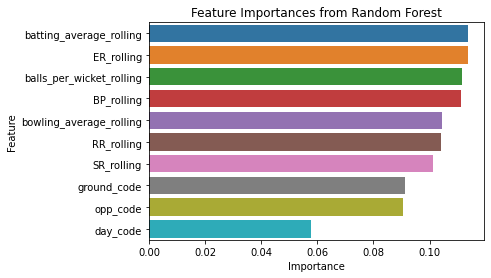

In [10]:
importances = best_model_rf.feature_importances_
feature_names = new_cols + predictors
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Tuning hyperparameters on a neural network using GridSearchCV

In [17]:
mlp = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(64,), (32,), (64, 32), (128, 64), (128, 128, 64)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [16, 64],
    'max_iter': [200, 1000]
}

random_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='precision_weighted')

def tune_nn(data, predictors):
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.dropna()
    train = data[data['Match Date'] < '2023-01-01']
    random_search.fit(train[predictors], train['target'])
    return random_search

In [18]:
tuned_model = tune_nn(matches_rolling, new_cols + predictors)

/Users/tomborrett/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomborrett/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomborrett/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tomborrett/opt/anaconda3/lib/python3

In [13]:
best_model_nn = random_search.best_estimator_
combined, precision = make_predictions_with_improved_model(best_model_nn, matches_rolling, new_cols + predictors)
precision

0.4944433218832087

In [14]:
best_model_nn.get_params

<bound method BaseEstimator.get_params of MLPClassifier(activation='tanh', batch_size=16, hidden_layer_sizes=(128, 64),
              learning_rate='adaptive', max_iter=500)>